In [1]:
# Importing the Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [2]:
# Importing the datasets

df_train = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
df_test = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv") 

print ("The shape of the train set given is : ", df_train.shape)
print ("The shape of the test set given is : ", df_test.shape)

df_train.head()

The shape of the train set given is :  (161297, 7)
The shape of the test set given is :  (53766, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
# Data types
df_train.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

We will merge both the datasets and do the preprocessing and exploratory data analysis for the whole dataset and after that, we will split the dataset later for training and testing

In [4]:
# Merging the test and train data 
merge = [df_train, df_test]
df_data = pd.concat(merge)

print (df_data.shape)

df_data.head(10)

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [5]:
df_data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [6]:
# Null values
print ("Null values in the dataset : ", df_data.isnull().sum(axis = 0))

Null values in the dataset :  uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


In [7]:
# Calculating what percentage of data is null
size = df_data.shape[0]

print ("Total Size of the dataset : ", size)

total_na = df_data.isnull().sum(axis = 0)['condition']
print ("Null values : ", total_na)

print ("PERCENTAGE : ", (total_na/size)*100)

Total Size of the dataset :  215063
Null values :  1194
PERCENTAGE :  0.5551861547546533


In [8]:
# Dropping the data points with null values as it's very much less than 5% of the whole dataset
df_data = df_data.dropna(how = 'any', axis = 0)

print ("The shape of the dataset after null values removal :", df_data.shape)

The shape of the dataset after null values removal : (213869, 7)


In [9]:
# lowercasing the column names so it will be easier for access ^^
df_data.columns = df_data.columns.str.lower()

In [10]:
# Sorting the dataframe
df_data.sort_values(['uniqueid'], ascending = True, inplace = True)
df_data.reset_index(drop = True, inplace = True)
df_data.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,24-Oct-15,3
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,22-Oct-15,6
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,21-Oct-15,2
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,20-Oct-15,2


In [11]:
# Total unique conditions in the dataset
print (df_data['condition'].nunique(), "\n")

print ("some of the conditions are : ", df_data['condition'].unique()[0:10])

916 

some of the conditions are :  ['Abnormal Uterine Bleeding' 'Amenorrhea' 'Birth Control' 'Endometriosis'
 'Endometrial Hyperplasia, Prophylaxis' 'Renal Cell Carcinoma'
 'Not Listed / Othe' 'Eye Redness' 'Benign Prostatic Hyperplasia' 'Acne']


In [12]:
# top 10 drugs with rating equals 1
df_data.loc[df_data['rating'] == 1, :]['drugname'].value_counts().head(10)

Miconazole                            767
Ethinyl estradiol / norethindrone     728
Etonogestrel                          707
Levonorgestrel                        511
Nexplanon                             504
Ethinyl estradiol / norgestimate      464
Medroxyprogesterone                   443
Depo-Provera                          417
Tioconazole                           410
Ethinyl estradiol / levonorgestrel    385
Name: drugname, dtype: int64

In [13]:
df_data.loc[df_data.usefulcount == 0, 'drugname'].value_counts()

Etonogestrel                         590
Levonorgestrel                       473
Ethinyl estradiol / norethindrone    371
Implanon                             327
Ethinyl estradiol / norgestimate     252
                                    ... 
Moderiba                               1
ProAir HFA                             1
Flibanserin                            1
Delsym 12 Hour Cough Relief            1
Letrozole                              1
Name: drugname, Length: 1487, dtype: int64

In [14]:
# Minimum rating in the dataset
df_data['rating'].min()

1

In [15]:
# Converting the date in to date time format 
df_data['date'] = pd.to_datetime(df_data['date'])

## Exploratory Data Analysis

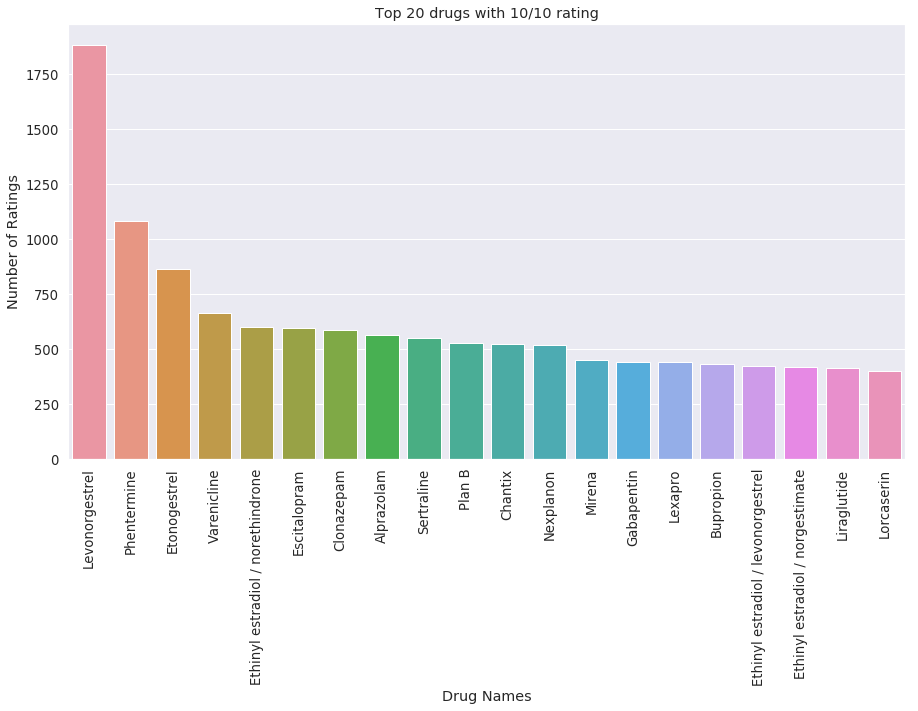

In [16]:
# This barplot shows the top 20 drugs with the 10/10 rating

# Setting the Parameters
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df_data.loc[df_data.rating == 10, "drugname"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set(title = 'Top 20 drugs with 10/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

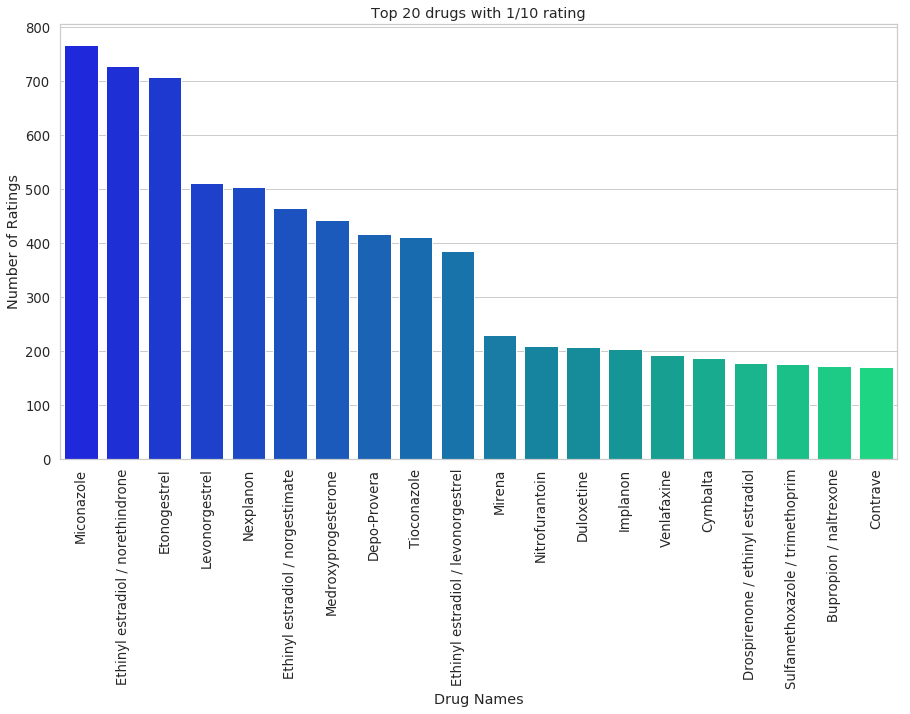

In [17]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df_data.loc[df_data.rating == 1, "drugname"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set(title = 'Top 20 drugs with 1/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")

plt.setp(sns_rating.get_xticklabels(), rotation=90);

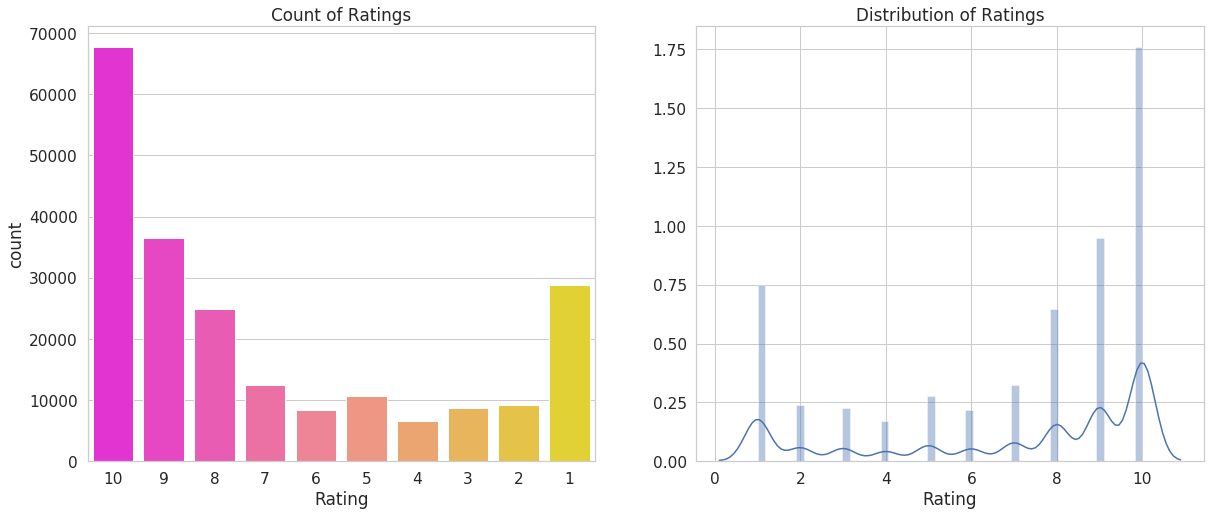

In [18]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(df_data['rating'], palette = 'spring', order = list(range(10, 0, -1)), ax = ax[0])
sns_2 = sns.distplot(df_data['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating");

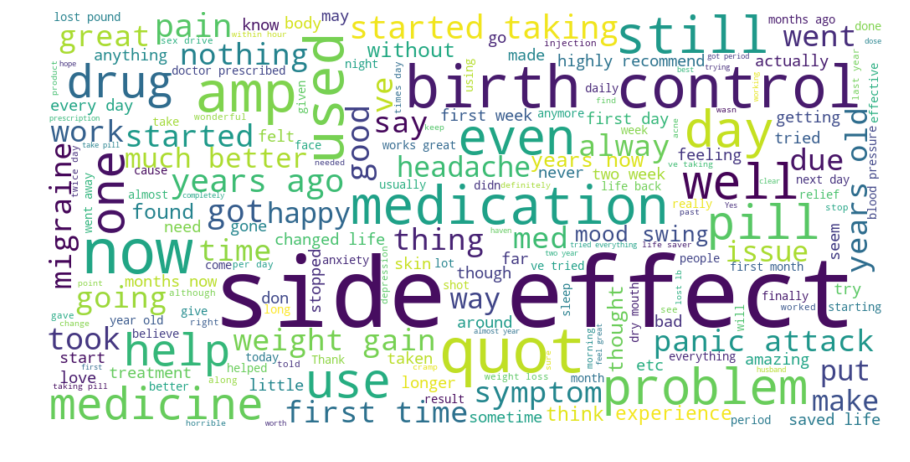

In [19]:
# Word cloud of the reviews with rating equal to 10

df_rate_ten = df_data.loc[df_data.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

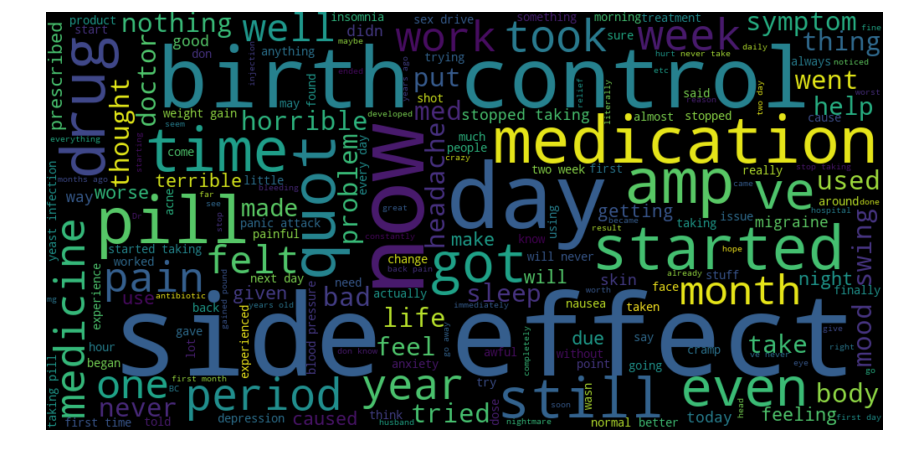

In [20]:
# Word cloud of the reviews with rating equal to 1

df_rate_one = df_data.loc[df_data.rating == 1, 'review']
k1 = (' '.join(df_rate_one))

wordcloud = WordCloud(width = 1000, height = 500).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

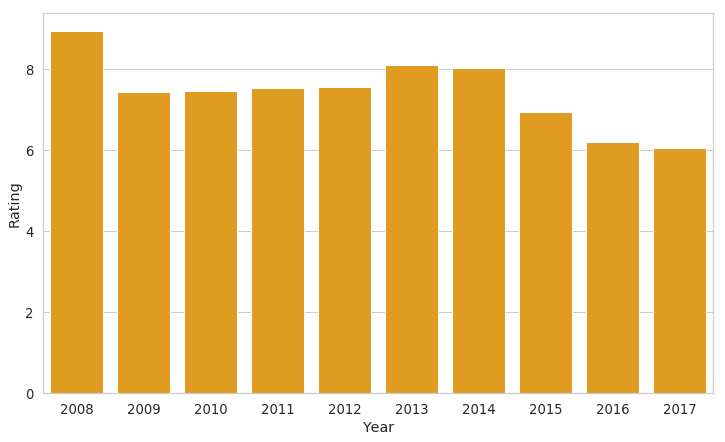

In [21]:
# This barplot shows the mean rating of the drugs per year

mean_rating = dict(df_data.groupby(df_data['date'].dt.year)['rating'].mean())
plt.rcParams['figure.figsize'] = [12, 7]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_ = sns.barplot(x = list(mean_rating.keys()), y = list(mean_rating.values()), color = 'orange');
sns_.set_xlabel("Year")
sns_.set_ylabel("Rating");

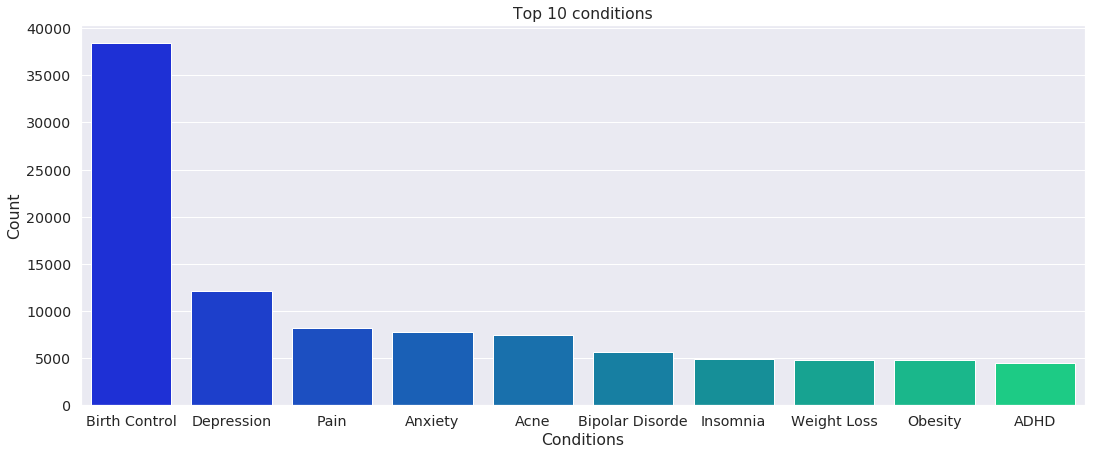

In [22]:
# This barplot show the top 10 conditions the people are suffering.

cond = dict(df_data['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

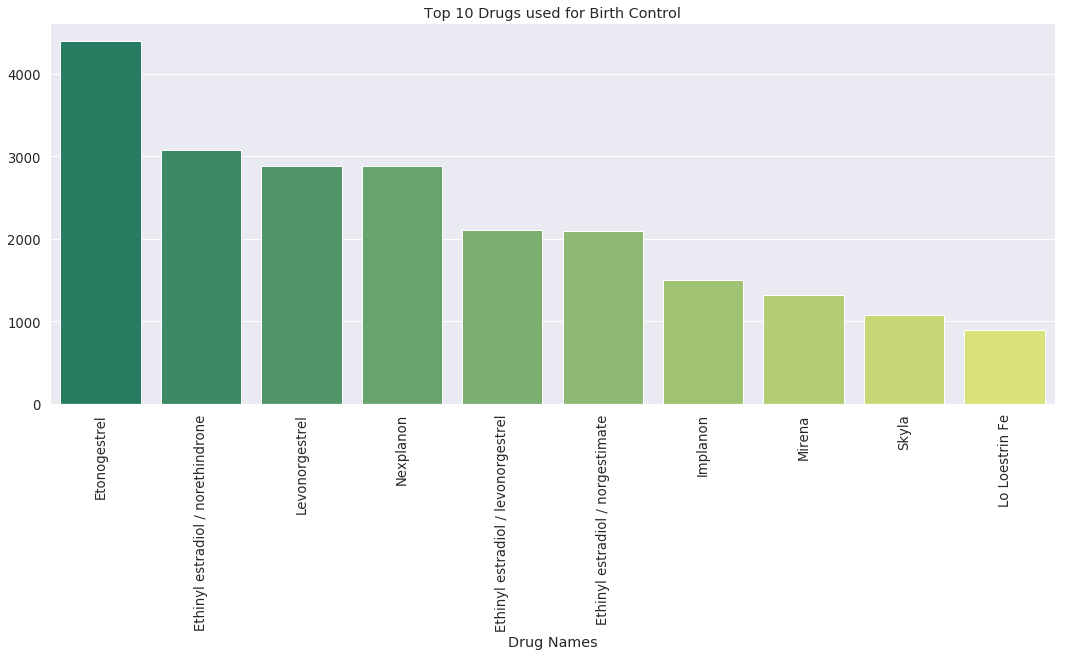

In [23]:
# Top 10 drugs which are used for the top condition, that is Birth Control

df = df_data[df_data['condition'] == 'Birth Control']['drugname'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df.index, y = df.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

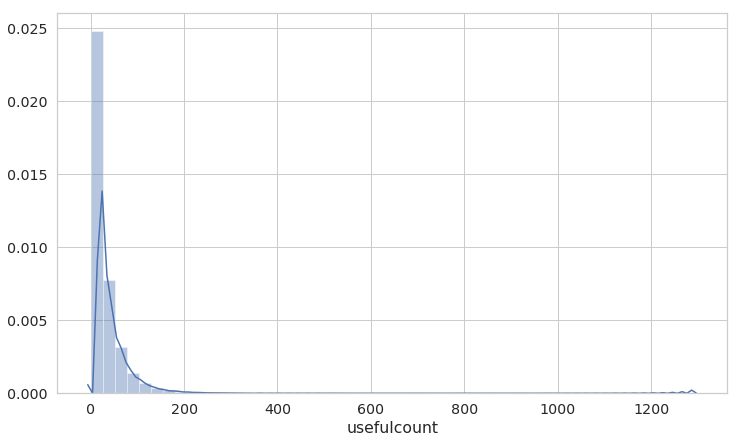

In [24]:
# Distribution of the useful count
sns.set(style = 'whitegrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [12, 7]
sns.distplot(df_data['usefulcount'].dropna())

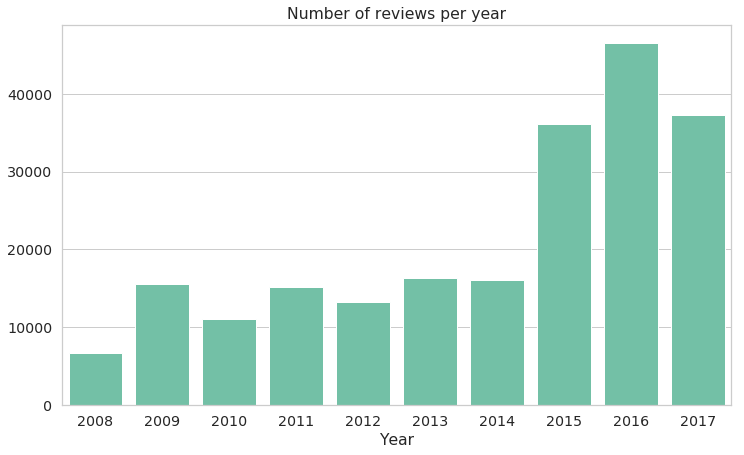

In [25]:
# This barplot shows the number of reviews per year
df = df_data['date'].dt.year.value_counts()
df = df.sort_index()

sns_ = sns.barplot(x = df.index, y = df.values, color = 'mediumaquamarine')
sns_.set_title("Number of reviews per year")
sns_.set_xlabel("Year");

## Preprocessing

We are going to use the threshold rating of 5 for giving the sentiment, The review will have a positive sentiment (1) if rating > 5 and negative sentiment otherwise.

In [31]:
# Giving the Sentiment according to the ratings
df_data['sentiment_rate'] = df_data['rating'].apply(lambda x: 1 if x > 5 else 0)

In [32]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [33]:
# Contraction Dictionary for the expansion

contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
    "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
    "you’re": "you are", "you’re": "you are", "you’ve": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [34]:
#df_data['review_clean'] = df_data['review'].apply(review_clean)
df_data['review_clean'] = review_clean(df_data['review'])

# Expanding the contractions
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: expand_contractions(x))

# Removing punctuations
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

In [35]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,been on the depo injection since january 2015 ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 years old and recently found out i might...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,i have been on the shot 11 years and until a m...
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive had four shots at this point i was on birt...
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,i had a total of 3 shots i got my first one be...


In [36]:
# Removing the stopwords
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [37]:
# Removing the word stems using the Snowball Stemmer
Snow_ball = SnowballStemmer("english")
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

In [38]:
df_data['review_clean'].head(20)

0     depo inject sinc januari 2015 bleed stop anoth...
1     im 21 year old recent found might pcos havent ...
2     shot 11 year month ago never 1 period even spo...
3     ive four shot point birth control pill year du...
4     total 3 shot got first one leav hospit give bi...
5     horribl shot got first shot august ever sinc e...
6     im 18 got heavi bleed ive alway heard bc make ...
7     im 19 heavi pain period sinc forev got depo sh...
8     im 30 year old woman got shot august 9th bleed...
9     im 17 year old got shot august 2015 person don...
10    first month awesom absolut wonder start light ...
11    start depo shot year ago origin bled 3 week da...
12    im 24 ive 2 year quit period last 3 week first...
13    im 17 went depo heavi bleed like heavi would g...
14    love conveni one shot everi three month look b...
15    1st shot sept 2nd nonstop bleed sinc side effe...
16    took shot safe im young teenag sexual activ bi...
17    ive shot 2 year amp one complaint skin cou

In [39]:
# Separating the day, month and year from the Date

df_data['day'] = df_data['date'].dt.day
df_data['month'] = df_data['date'].dt.month
df_data['year'] = df_data['date'].dt.year

In [40]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,month,year
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,10,2015
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,10,2015
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,10,2015
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,10,2015
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,10,2015


In [41]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [42]:
df_data['sentiment'] = sentiment(df_data['review'])

In [43]:
df_data['sentiment_clean'] = sentiment(df_data['review_clean'])

In [44]:
np.corrcoef(df_data['sentiment'], df_data['rating'])

array([[1.       , 0.3481753],
       [0.3481753, 1.       ]])

In [45]:
np.corrcoef(df_data['sentiment_clean'], df_data['rating'])

array([[1.        , 0.23328381],
       [0.23328381, 1.        ]])

The Correlation coefficient between the sentiment of the uncleaned review with rating is greater than the cleaned review, so now lets try without the snowball stemmer and without removing the stopwords.

In [46]:
# Cleaning the reviews without removing the stop words and using snowball stemmer

df_data['review_clean_ss'] = review_clean(df_data['review'])

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: expand_contractions(x))

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

df_data['sentiment_clean_ss'] = sentiment(df_data['review_clean_ss'])

In [47]:
np.corrcoef(df_data['sentiment_clean_ss'], df_data['rating'])

array([[1.        , 0.34600372],
       [0.34600372, 1.        ]])

In [48]:
df_data.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,month,year,sentiment,sentiment_clean,review_clean_ss,sentiment_clean_ss
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,10,2015,-0.287798,-0.127381,been on the depo injection since january 2015 ...,-0.160714
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,10,2015,0.175357,0.161429,im 21 years old and recently found out i might...,0.175357
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,10,2015,-0.210000,0.233333,i have been on the shot 11 years and until a m...,-0.210000
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,10,2015,-0.022500,0.069444,ive had four shots at this point i was on birt...,-0.033333
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,10,2015,0.044872,0.103333,i had a total of 3 shots i got my first one be...,0.044872
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,2015-10-24,3,0,horribl shot got first shot august ever sinc e...,24,10,2015,0.000321,0.013235,this is a horrible shot i got my first shot in...,0.000321
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5,2015-10-22,6,0,im 18 got heavi bleed ive alway heard bc make ...,22,10,2015,-0.056692,0.098052,im 18 and got this for heavy bleeding ive alwa...,-0.065025
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5,2015-10-21,2,0,im 19 heavi pain period sinc forev got depo sh...,21,10,2015,0.030995,0.068750,im 19 and have been having heavy and painful p...,0.026923
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,2015-10-21,5,0,im 30 year old woman got shot august 9th bleed...,21,10,2015,0.265309,0.288889,im a 30 year old woman i got the shot on augus...,0.265309
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7,2015-10-20,2,1,im 17 year old got shot august 2015 person don...,20,10,2015,-0.047222,-0.022500,im 17 years old and i got shot in august 2015 ...,-0.047222


## Feature Engineering

In [49]:
#Word count in each review
df_data['count_word']=df_data["review_clean_ss"].apply(lambda x: len(str(x).split()))

#Unique word count 
df_data['count_unique_word']=df_data["review_clean_ss"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_data['count_letters']=df_data["review_clean_ss"].apply(lambda x: len(str(x)))

#punctuation count
df_data["count_punctuations"] = df_data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_data["count_words_upper"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_data["count_words_title"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_data["count_stopwords"] = df_data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
df_data["mean_word_len"] = df_data["review_clean_ss"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [50]:
df_data.columns

Index(['uniqueid', 'drugname', 'condition', 'review', 'rating', 'date',
       'usefulcount', 'sentiment_rate', 'review_clean', 'day', 'month', 'year',
       'sentiment', 'sentiment_clean', 'review_clean_ss', 'sentiment_clean_ss',
       'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_words_upper', 'count_words_title',
       'count_stopwords', 'mean_word_len'],
      dtype='object')

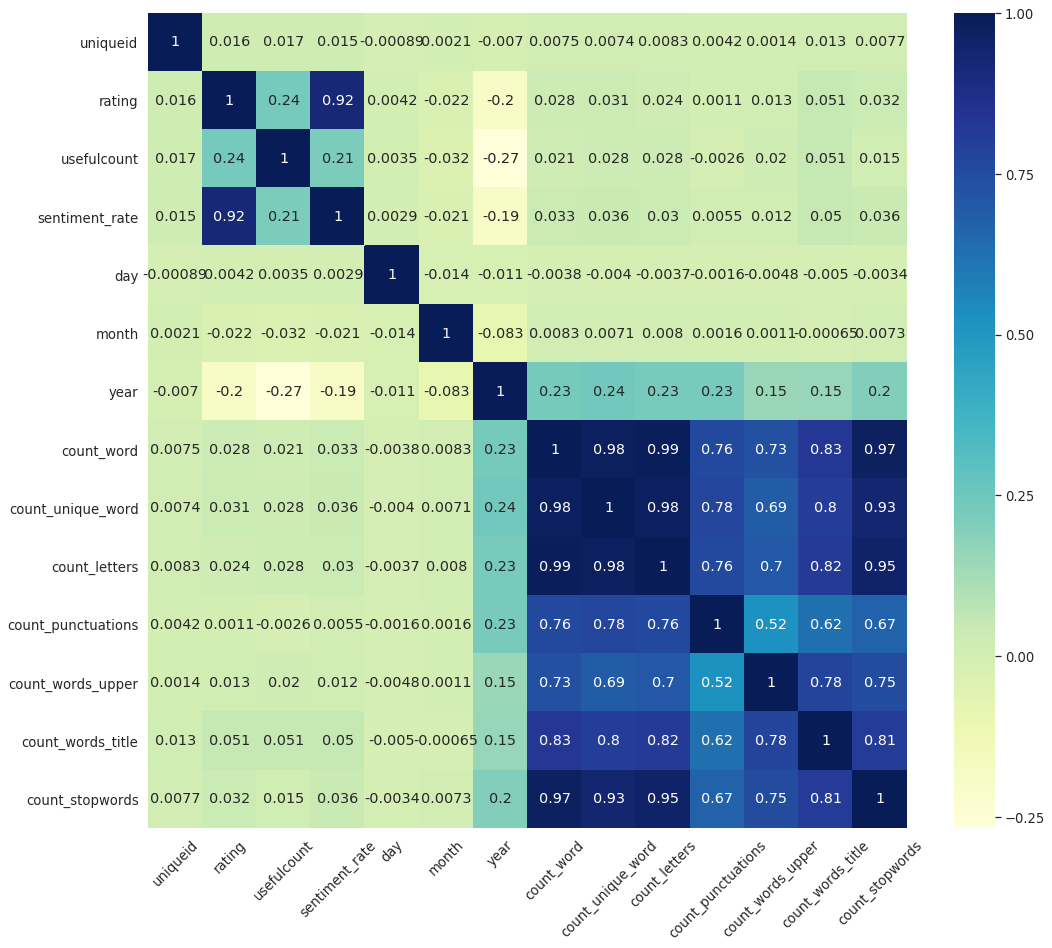

In [51]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = df_data.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [52]:
# Label Encoding Drugname and Conditions
label_encoder_feat = {}
for feature in ['drugname', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df_data[feature] = label_encoder_feat[feature].fit_transform(df_data[feature])

## Modelling

In [53]:
# Defining Features and splitting the data as train and test set

features = df_data[['condition', 'usefulcount', 'sentiment', 'day', 'month', 'year',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords', 'mean_word_len']]

target = df_data['sentiment_rate']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149708, 15)
The Test set size  (64161, 15)


Model - I LightGBM

In [54]:
# Training Model - I

clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions), '\n')

print (classification_report(y_test, predictions))

The Accuracy of the model is :  0.8881095992892879 

The confusion Matrix is 

[[14771  4574]
 [ 2605 42211]] 

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     19345
           1       0.90      0.94      0.92     44816

    accuracy                           0.89     64161
   macro avg       0.88      0.85      0.86     64161
weighted avg       0.89      0.89      0.89     64161



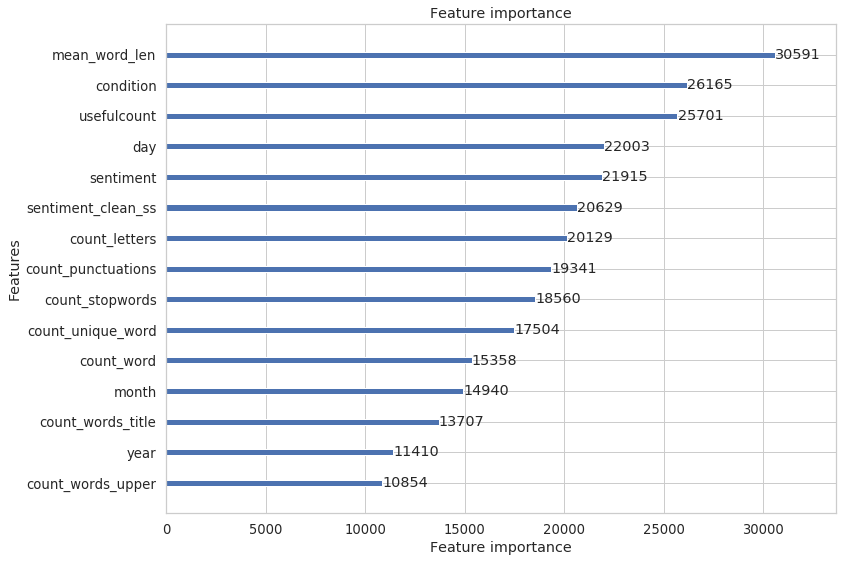

In [55]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(model);